In [68]:
import torch
import numpy as np
from equivariant_diffusion.en_diffusion import PredefinedNoiseSchedule
import matplotlib.pyplot as plt
from torch_scatter import scatter_add, scatter_mean

In [69]:
lig_sizes = torch.tensor([14, 13, 12, 10])
pocket_sizes = torch.tensor([28, 27, 32, 24])
xh_lig = torch.randn(lig_sizes.sum(), 13)
xh_pocket = torch.randn(pocket_sizes.sum(), 23)
mask_lig, mask_pocket = [], []
for i in range(4):
    mask_lig.extend([i] * lig_sizes[i])
    mask_pocket.extend([i] * pocket_sizes[i])
mask_lig = torch.tensor(mask_lig)
mask_pocket = torch.tensor(mask_pocket)
xh_lig.shape, xh_pocket.shape, mask_lig.shape, mask_pocket.shape

(torch.Size([49, 13]),
 torch.Size([111, 23]),
 torch.Size([49]),
 torch.Size([111]))

In [72]:
def inflate_batch_array(array, target):
        """
        Inflates the batch array (array) with only a single axis
        (i.e. shape = (batch_size,), or possibly more empty axes
        (i.e. shape (batch_size, 1, ..., 1)) to match the target shape.
        """
        target_shape = (array.size(0),) + (1,) * (len(target.size()) - 1)
        return array.view(target_shape)

def alpha(gamma, target_tensor):
        """Computes alpha given gamma."""
        return inflate_batch_array(torch.sqrt(torch.sigmoid(-gamma)),
                                        target_tensor)

def sigma(gamma, target_tensor):
        return inflate_batch_array(torch.sqrt(torch.sigmoid(gamma)),
                                        target_tensor)

def sum_except_batch(x, indices):
        return scatter_add(x.sum(-1), indices, dim=0)

def subspace_dimensionality(input_size):
        """Compute the dimensionality on translation-invariant linear subspace
        where distributions on x are defined."""
        return (input_size - 1) * 3

def gaussian_KL(q_mu_minus_p_mu_squared, q_sigma, p_sigma, d):
        """Computes the KL distance between two normal distributions.
            Args:
                q_mu_minus_p_mu_squared: Squared difference between mean of
                    distribution q and distribution p: ||mu_q - mu_p||^2
                q_sigma: Standard deviation of distribution q.
                p_sigma: Standard deviation of distribution p.
                d: dimension
            Returns:
                The KL distance
            """
        return d * torch.log(p_sigma / q_sigma) + \
               0.5 * (d * q_sigma ** 2 + q_mu_minus_p_mu_squared) / \
               (p_sigma ** 2) - 0.5 * d

gamma = PredefinedNoiseSchedule("polynomial_2", timesteps=500, precision=5.0e-4)


In [73]:
def kl_prior_with_pocket(xh_lig, xh_pocket, mask_lig, mask_pocket,
                             num_nodes):
        """Computes the KL between q(z1 | x) and the prior p(z1) = Normal(0, 1).

        This is essentially a lot of work for something that is in practice
        negligible in the loss. However, you compute it so that you see it when
        you've made a mistake in your noise schedule.
        """
        n_dims = 3
        batch_size = len(num_nodes)

        # Compute the last alpha value, alpha_T.
        ones = torch.ones((batch_size, 1), device=xh_lig.device)
        gamma_T = gamma(ones)
        alpha_T = alpha(gamma_T, xh_lig)

        print("alpha_T", alpha_T[0])
        print("gamma_T", gamma_T[0])

        # Compute means.
        mu_T_lig = alpha_T[mask_lig] * xh_lig
        mu_T_lig_x, mu_T_lig_h = mu_T_lig[:, :n_dims], \
                                 mu_T_lig[:, n_dims:]
        print("mu_T_lig_x.shape = ", mu_T_lig_x.shape)
        print("mu_T_lig_h.shape = ", mu_T_lig_h.shape)

        # Compute standard deviations (only batch axis for x-part, inflated for h-part).
        sigma_T_x = sigma(gamma_T, mu_T_lig_x).squeeze()
        sigma_T_h = sigma(gamma_T, mu_T_lig_h).squeeze()
        print("sigma_T_x[0] ", sigma_T_x[0])

        # Compute means.
        mu_T_pocket = alpha_T[mask_pocket] * xh_pocket
        mu_T_pocket_x, mu_T_pocket_h = mu_T_pocket[:, :n_dims], \
                                       mu_T_pocket[:, n_dims:]

        # Compute KL for h-part.
        zeros_lig = torch.zeros_like(mu_T_lig_h)
        zeros_pocket = torch.zeros_like(mu_T_pocket_h)
        ones = torch.ones_like(sigma_T_h)
        mu_norm2 = sum_except_batch((mu_T_lig_h - zeros_lig) ** 2, mask_lig) + \
                   sum_except_batch((mu_T_pocket_h - zeros_pocket) ** 2, mask_pocket)
        print("mu_norm2.shape", mu_norm2.shape)
        kl_distance_h = gaussian_KL(mu_norm2, sigma_T_h, ones, d=1)
        print("kl_distance_h.shape", kl_distance_h.shape)

        # Compute KL for x-part.
        zeros_lig = torch.zeros_like(mu_T_lig_x)
        zeros_pocket = torch.zeros_like(mu_T_pocket_x)
        ones = torch.ones_like(sigma_T_x)
        mu_norm2 = sum_except_batch((mu_T_lig_x - zeros_lig) ** 2, mask_lig) + \
                   sum_except_batch((mu_T_pocket_x - zeros_pocket) ** 2, mask_pocket)
        subspace_d = subspace_dimensionality(num_nodes)
        print("subspace_d", subspace_d)
        kl_distance_x = gaussian_KL(mu_norm2, sigma_T_x, ones, subspace_d)
        print("kl_distance_x.shape", kl_distance_x.shape)

        return kl_distance_x + kl_distance_h


out = kl_prior_with_pocket(xh_lig, xh_pocket, mask_lig, mask_pocket, lig_sizes + pocket_sizes)

alpha_T tensor([0.0224])
gamma_T tensor([7.6004])
mu_T_lig_x.shape =  torch.Size([49, 3])
mu_T_lig_h.shape =  torch.Size([49, 10])
sigma_T_x[0]  tensor(0.9997)
mu_norm2.shape torch.Size([4])
kl_distance_h.shape torch.Size([4])
subspace_d tensor([123, 117, 129,  99])
kl_distance_x.shape torch.Size([4])


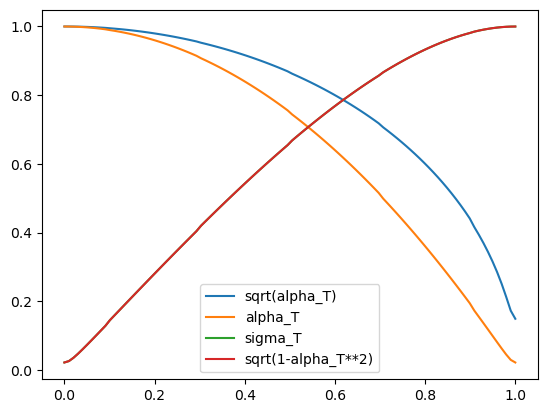

In [58]:
a = np.linspace(0, 1, 100)
gamma_T = gamma(torch.tensor(a).unsqueeze(1))
alpha_T = torch.sqrt(torch.sigmoid(-gamma_T))
sigma_T = torch.sqrt(torch.sigmoid(gamma_T))
# plt.plot(a, gamma_T)
plt.plot(a, np.sqrt(alpha_T), label="sqrt(alpha_T)")
plt.plot(a, alpha_T, label="alpha_T")
plt.plot(a, sigma_T, label="sigma_T")
plt.plot(a, np.sqrt(1-alpha_T**2), label="sqrt(1-alpha_T**2)")
plt.legend()
# plt.plot(a, np.sqrt(alpha_T))